TODO: intro à faire à la fin quand tout sera finalisé

Le but de ce notebook est de présenter les différentes méthodes de représentation implicite utilisées au laboratoire. Pour bien utiliser ce notebook, vous aurez besoin:
-D'une image IRM 4D, idéalement l'image sub_E01_dynamic_MovieClear_active_run_12.nii.gz qui peut être trouvé sur le DD de Patty (Equinus)
-Un ordinateur équipé d'un gpu

Nous allons d'abord retrouver la fonction image d'un volume, avant d'essayer de l'interpoler dans le temps

Add: typespes of models, pytorch version, tinycuda version

In [1]:
#Nous importons les modules classiques

import torch #bibliothèque de deep learning
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import nibabel as nib
import math
import tinycudann as tcnn



/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Commençons par charger l'image d'IRM 4D

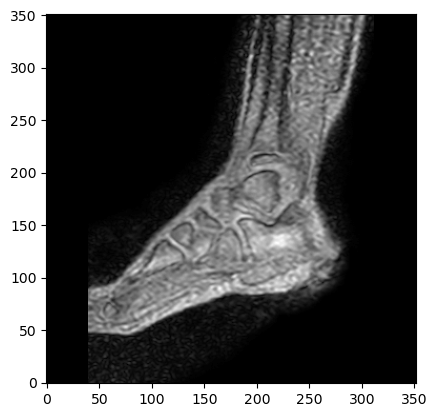

In [2]:
#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'
mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3, 7] #Je visualise la 3 slice et la 7eme frame

plt.imshow(data.T, origin='lower', cmap='gray')

Nous créons maintenant le dataset et le dataloader.

In [3]:
batch_size = 5000
epochs = 50
dim_hidden = 352

image_shape = data.shape
dim_in = len(data.shape)

#On tensorise nos données puis on normalise entre -1 et 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() * 2 - 1 

#Creation de la grille de coordonnées en points d'entrée
axes = []
for s in image_shape:
    axes.append(torch.linspace(-1, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in) #Je tensorise la grille

dataset = torch.utils.data.TensorDataset(X, Y)  #une coordonnée est associée à une valeur y

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))
print(train_batch) #l'ordre des coordonnées est aléatoire, utilisé pour l'entrainement
print(test_batch) #l'ordre des coordonnées est croissant, utilisé pour les prédictions

[tensor([[ 0.7493,  0.6695],
        [-0.4815, -0.3504],
        [ 0.3276,  0.0769],
        ...,
        [ 0.9487,  0.7607],
        [-0.9601,  0.4872],
        [ 0.4587, -0.0997]]), tensor([[-1.0000],
        [ 0.0380],
        [ 0.2658],
        ...,
        [-1.0000],
        [-1.0000],
        [ 0.4177]])]
[tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9943],
        [-1.0000, -0.9886],
        ...,
        [-0.9202, -0.6068],
        [-0.9202, -0.6011],
        [-0.9202, -0.5954]]), tensor([[-1.],
        [-1.],
        [-1.],
        ...,
        [-1.],
        [-1.],
        [-1.]])]


Le premier modèle à explorer est le siren. Un siren est un MLP dont les fonctions d'activations sont fonctions périodiques. Concrètement, on remplace la ReLU usuellement utilisée par une fonction sin(x).

Les sirens convergent très rapidement quand ils sont correctement initialisés, et présentent l'avantage d'être infiniments dérivables. Cette dernière propriété peut être utile pour utiliser des schémas de régularisation avancée, comme par exemple dans le papier "Implicit Neural Representations for Deformable Image Registration".

En revanche, ils sont très sensibles aux conditions d'initialisation et peuvent être délicats à entrainer correctement (source: papier siren).

In [4]:
'''
Reference: Sitzmann et al, Implicit Neural Representations with Periodic Activation Functions

Notebook: https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb#scrollTo=39Mf3epV8Ib2

'''

#utilitaires pour Siren
def exists(val):
    return val is not None


def cast_tuple(val, repeat=1):
    return val if isinstance(val, tuple) else ((val,) * repeat)


class Sine(nn.Module):
    def __init__(self, w0=30.0):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)


class Siren(nn.Module):
    '''
    Une couche Siren
    ARGS:
        w0: facteur multiplicatif tel que f(x) = sin(w0 * x)
        c: spread des poids lors de l'initialisation de la couche. 
    '''
    def __init__(
        self,
        dim_in,
        dim_out,
        w0=30.0,
        c=6.0,
        is_first=False,
        use_bias=True,
        activation=None,
    ):
        super().__init__()
        self.dim_in = dim_in
        self.is_first = is_first

        weight = torch.zeros(dim_out, dim_in)
        bias = torch.zeros(dim_out) if use_bias else None
        self.init_(weight, bias, c=c, w0=w0)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias) if use_bias else None
        self.activation = Sine(w0) if activation is None else activation

    def init_(self, weight, bias, c, w0):
        dim = self.dim_in

        w_std = (1 / dim) if self.is_first else (math.sqrt(c / dim) / w0)
        weight.uniform_(-w_std, w_std)

        if exists(bias):
            bias.uniform_(-w_std, w_std)

    def forward(self, x):
        out = F.linear(x, self.weight, self.bias)
        out = self.activation(out)
        return out


# siren network
class SirenNet(pl.LightningModule):
    '''
    PURPOSE:
        Implicit representation of arbitrary functions. Mainly used for 2D, 3D image interpolation
    ATTRIBUTES:
        dim_in: dimension of input
        dim_hidden: dimmension of hidden layers. 128-256 are recommended values
        dim_out: dimension of output
        num_layers: number of layers
        w0: multiplying factor so that f(x) = sin(w0 * x) between layers. Recommended value, 30.0
        w0_initial: see w0, recommended value 30.0 as per paper (See paper 'Implicit Neural Representations with Periodic Activation Functions' sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of factor 30)
        use_bias: if bias is used between layers, usually set to True
        final_activation: flexible last activation for tasks other than interpolation. None means identity
        lr: recommended 1e-4
        layers: layers of the model, minus last layer
        last_layer: final layer of model
        losses: list of losses during training
    METHODS:
        forward: forward pass
        training step: forward pass + backprop
        predict step: used for inference
        configure_optimizer: optimizer linked to model
    '''
    def __init__(
        self,
        dim_in: int = 3,
        dim_hidden: int = 352,
        dim_out: int = 1,
        num_layers: int = 4,
        w0=30.0,
        w0_initial=30.0,
        c=6.0,
        use_bias=True,
        final_activation=None,
        lr=1e-4,
        *args,
        **kwargs
    ):
        super().__init__()
        self.num_layers = num_layers
        self.dim_hidden = dim_hidden
        self.c = c
        self.losses = []
        self.lr = lr

        self.layers = nn.ModuleList([])
        for ind in range(num_layers):
            is_first = ind == 0
            layer_w0 = w0_initial if is_first else w0
            layer_dim_in = dim_in if is_first else dim_hidden

            self.layers.append(
                Siren(
                    dim_in=layer_dim_in,
                    dim_out=dim_hidden,
                    w0=layer_w0,
                    c=self.c,
                    use_bias=use_bias,
                    is_first=is_first,
                )
            )

        final_activation = (
            nn.Identity() if not exists(final_activation) else final_activation
        )
        self.last_layer = Siren(
            dim_in=dim_hidden,
            dim_out=dim_out,
            w0=w0,
            c=self.c,
            use_bias=use_bias,
            activation=final_activation,
        )

    def forward(self, x, mods=None):
        mods = cast_tuple(mods, self.num_layers)

        for layer, mod in zip(self.layers, mods):
            x = layer(x)

            if exists(mod):
                # x *= rearrange(mod, "b d -> b () d") #From Quentin: "d -> () d" -> "b d ->b () d" allors for several batches (images) to be processed
                x *= mod

        return self.last_layer(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self(x)

        loss = F.mse_loss(z, y)
        self.losses.append(loss.detach().cpu().numpy())

        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
model = SirenNet(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
)

model

SirenNet(
  (layers): ModuleList(
    (0): Siren(
      (activation): Sine()
    )
    (1): Siren(
      (activation): Sine()
    )
    (2): Siren(
      (activation): Sine()
    )
    (3): Siren(
      (activation): Sine()
    )
  )
  (last_layer): Siren(
    (activation): Identity()
  )
)

In [5]:
'''
Declaration du trainer, le trainer est utilisé pour entrainer le modèle en appelant la fonction 'training_step' de celui-ci via 'fit'
'''

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32, #16 ou 32. 16 pour automated mixed precision, voir https://developer.nvidia.com/automatic-mixed-precision
)

trainer.fit(model, train_loader)

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layers     | ModuleList | 373 K 
1 | last_layer | Siren      | 353   
------------------------------------------
374 K     Trainable params
0         Non-trainable params
374 K     Total params
1.497     Total estimated model params size (MB)
/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The 

Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 21.51it/s, loss=0.000622, v_num=86]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 21.19it/s, loss=0.000622, v_num=86]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 115.13it/s]


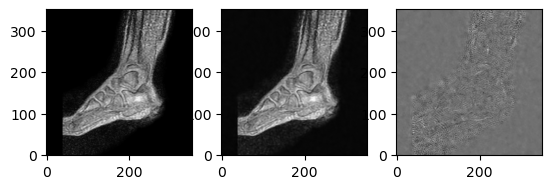

In [7]:
'''
Une prédiction est inférée et reformée à la forme de l'image d'origine
'''

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

gt = data / data.max() * 2 - 1

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Essayez de changer le type de normalisation de Y. Quel est l'effet observé ? Pourquoi à t'on choisi une normalisation entre -1 et 1 ?

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layers     | ModuleList | 373 K 
1 | last_layer | Siren      | 353   
------------------------------------------
374 K     Trainable params
0         Non-trainable params
374 K     Total params
0.748     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 21.97it/s, loss=0.000621, v_num=87]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 21.64it/s, loss=0.000621, v_num=87]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 154.13it/s]


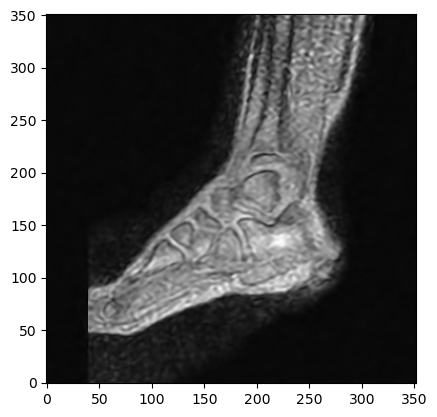

In [8]:
#On peut utiliser la mixed precision pour accélérer les entrainements
model = SirenNet(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=16,
)

trainer.fit(model, train_loader)

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

fig, axes = plt.subplots(1, 3)

diff = im - gt

axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Attention ! Dans certains cas (entrainements 4D notamment), passer en 32bits->16bits precision peut empêcher le modèle de converger correctement.

In [5]:
'''
Refaisons la même expérience en intégrant la dimension temporelle
'''

batch_size = 30000
epochs = 50

#On augmente la dimension de l'image
mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:] #largeur, hauteur, nombre de slices, nombre de frames
image_shape = data.shape
dim_in = len(data.shape)
#data.transpose()

Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() * 2 -1

axes = []
for s in image_shape:
    axes.append(torch.linspace(-1, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layers     | ModuleList | 374 K 
1 | last_layer | Siren      | 353   
------------------------------------------
374 K     Trainable params
0         Non-trainable params
374 K     Total params
1.498     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 62/62 [00:04<00:00, 13.71it/s, loss=0.00183, v_num=123]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 62/62 [00:04<00:00, 13.66it/s, loss=0.00183, v_num=123]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 62/62 [00:01<00:00, 33.43it/s]


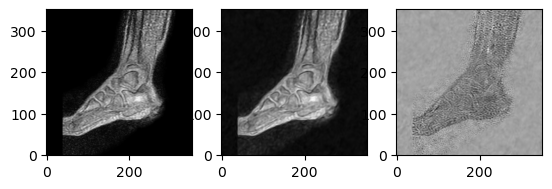

In [13]:
model = SirenNet(dim_in=dim_in,
                 dim_hidden=dim_hidden)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)
pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 7]

gt = data[..., 7]
gt = gt /gt.max() * 2 - 1

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Du flou commence à apparaitre.
Essayez de manipuler les paramètres pour améliorer la qualité image. Quels paramètres ont le plus d'influence ? 
Essayez de faire cette expérience en 4D, comment foit évoluer la 'dim_hidden' pour garder une qualité d'image correcte ? Quelle est la limite ?

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layers     | ModuleList | 6.0 M 
1 | last_layer | Siren      | 1.4 K 
------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.835    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 62/62 [00:09<00:00,  6.34it/s, loss=0.00235, v_num=146]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 62/62 [00:09<00:00,  6.26it/s, loss=0.00235, v_num=146]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 62/62 [00:02<00:00, 24.07it/s]


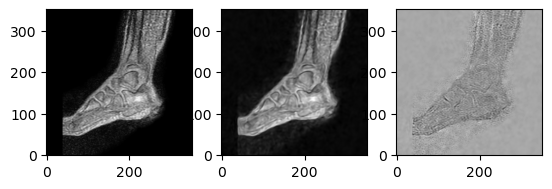

In [6]:
model = SirenNet(dim_in=dim_in,
                 dim_hidden=dim_hidden * 4)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)
pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 7]

gt = data[..., 7]
gt = gt /gt.max() * 2 - 1

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Augmenter le dim_hidden du modèle, et donc son expressivité, résout partiellement le problème, mais n'est pas suffisant.

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layers     | ModuleList | 6.0 M 
1 | last_layer | Siren      | 1.4 K 
------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.835    Total estimated model params size (MB)
/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The 

Epoch 149: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s, loss=0.000661, v_num=149]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 21/21 [00:11<00:00,  1.77it/s, loss=0.000661, v_num=149]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:02<00:00,  8.00it/s]


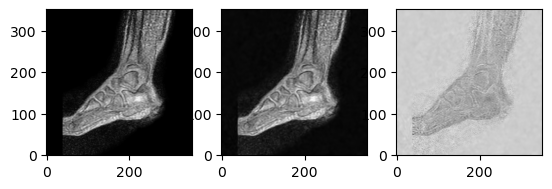

In [9]:
'''
Refaisons la même expérience en intégrant la dimension temporelle TODO: just adjust batch size if you want
'''

batch_size = 30000 * 3
epochs = 50 * 3 #same number of gradient steps

#On augmente la dimension de l'image
mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:] #largeur, hauteur, nombre de slices, nombre de frames
image_shape = data.shape
dim_in = len(data.shape)
#data.transpose()

Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() * 2 -1

axes = []
for s in image_shape:
    axes.append(torch.linspace(-1, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = SirenNet(dim_in=dim_in,
                 dim_hidden=dim_hidden * 4)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)
pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 7]

gt = data[..., 7]
gt = gt /gt.max() * 2 - 1

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Un modulateur peut être utiliser pour enrichir la gamme d'expression du Siren

In [11]:
'''
Reference: Mehta et al.: Modulated Periodic Activations for Generalizable Local Functional Representations
'''

class Modulator(nn.Module):
    """
    Modulator as per paper 'Modulated periodic activations for generalizable local functional representations'
    """
    def __init__(self, dim_in, dim_hidden, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([])

        for ind in range(num_layers):
            is_first = ind == 0
            dim = dim_in if is_first else (dim_hidden + dim_in)

            self.layers.append(nn.Sequential(nn.Linear(dim, dim_hidden), nn.LeakyReLU()))

    def forward(self, z):
        x = z
        hiddens = []

        for layer in self.layers:
            x = layer(x)
            hiddens.append(x)
            x = torch.cat((x, z), dim=1)

        return tuple(hiddens)

class ModulatedSirenNet(pl.LightningModule):
    """
    Lightning module for modulated siren. Each layer of the modulation is element-wise multiplied with the corresponding siren layer
    """

    def __init__(
        self,
        dim_in=3,
        dim_hidden=352,
        dim_out=1,
        num_layers=4,
        w0=30.0,
        w0_initial=30.0,
        c=12.0,
        use_bias=True,
        final_activation=None,
        lr=1e-4,
        *args,
        **kwargs
    ):
        super().__init__()
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.num_layers = num_layers
        self.w0 = w0
        self.w0_initial = w0_initial
        self.c = c
        self.use_bias = use_bias
        self.final_activation = final_activation
        self.lr = lr
        self.losses = []

        # networks
        self.modulator = Modulator(
            dim_in=self.dim_in, dim_hidden=self.dim_hidden, num_layers=self.num_layers
        )
        self.siren = SirenNet(
            dim_in=self.dim_in,
            dim_hidden=self.dim_hidden,
            dim_out=self.dim_out,
            num_layers=self.num_layers,
            w0=self.w0,
            w0_initial=self.w0_initial,
            c=self.c,
            use_bias=self.use_bias,
            final_activation=self.final_activation,
            lr=self.lr,
        )

    def forward(self, x):
        mods = self.modulator(x)

        mods = cast_tuple(mods, self.num_layers)

        for layer, mod in zip(self.siren.layers, mods):

            x = layer(x)

            x *= mod

        return self.siren.last_layer(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self(x)

        loss = F.mse_loss(z, y)
        self.losses.append(loss.detach().cpu().numpy())

        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)
    


In [16]:
'''
Les éléments nécessaire à l'entrainement sont déclarés
'''

Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() * 2 - 1

axes = []
for s in image_shape:
    axes.append(torch.linspace(-1, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = ModulatedSirenNet(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)
pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 7]

gt = data[..., 7]
gt = gt /gt.max() * 2 - 1

diff = im - gt

fig, axes = plt.subplots(1, 3)

axes[0].imshow(gt.T, origin='lower', cmap='gray')
axes[1].imshow(im.T, origin='lower', cmap='gray')
axes[2].imshow(diff.T, origin='lower', cmap='gray')
     
plt.show()

Mais ne fonctionne pas pour notre cas (à travailler, il est possible de corriger le modulateur). On peut utiliser un autre type de représentation implicite, le hash encoding

La base du hash encoding est une "simple" hashtable. Dans le modèle que nous allons voir, chaque coordonnée de X est associée à un certain nombre de paramètres répartis dans plusieurs hashtables. Ces paramètres sont appris et vont être ajustés normalement durant la backpropagation. Cet espace de paramètres représente une représentation latent qu'un décodeur (un simple MLP) va se charger de décoder en image. Voir l'excellent figure du papier "Instant Neural Graphics Primitives with a Multiresolution Hash Encoding" pour plus de détails.

Il n'y a pas de gestion explicite de collisions dans le cas ou deux coordonnées renvoient la même clé de hash. Le decoder scale avec le nombre de tables de hash mais pas avec la dimension des coordonnées d'entrée

Le grand avantage de ce modèle est qu'il est très flexible et robuste. Il est très rare de voir un entrainement partir complètement dans les choux. Par ailleurs, il scale bien si on ajoute des dimensions.

En revanche, le nombre de paramètres à ajuster est très important. Ce modèle converge souvent moins rapidemment que les modèles périodiques (Siren et Random Fourier Features). Par ailleurs, puisque le nombre de paramètres dans les table sde hash est très important, il faut faire beaucoup d'epochs pour tous les ajuster, même si le décoder a déjà convergé. Avec un petit nombre d'epochs, on observe souvent des "trous" lors de la prédiction

In [3]:
'''
Reference papers:
    Principe de base et gestion des collisions: Teschner et al. - Optimized Spatial Hashing for Collision Detection .pdf 
    Présentation de Tinycuda: Müller et al. Instant Neural Graphics Primitives with a Multiresolution Hash Encoding // Github repository disponbile sur Nvidia
    Utilisation dans le cadre de la recherche fetale: Junshen et al. NeSVoR: Implicit Neural Representation for Slice-to-Volume Reconstruction in MRI // Github repository disponible


Nous allons utiliser la bibiothèque tinycudann disponible sur le repository de Nvidia. Cette bibiothèque nécéssite impérativement un GPU pour être utilisée.
'''

from encoding import MultiResHashGrid, MultiResHashGridV2 #version full python du hash encoding

class HashMLP(pl.LightningModule):
    '''
    Lightning module for HashMLP. 
    '''
    def __init__(
        self,
        dim_in,
        dim_hidden,
        dim_out,
        n_layers,
        encoder_type,
        n_levels,
        n_features_per_level,
        log2_hashmap_size,
        base_resolution,
        finest_resolution,
        per_level_scale,
        interpolation,
        lr,
        *args,
        **kwargs
    ):
        super().__init__()
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.n_layers = n_layers
        self.encoder_type = encoder_type
        self.n_levels = n_levels
        self.n_features_per_level = n_features_per_level
        self.log2_hashmap_size = log2_hashmap_size
        self.base_resolution = base_resolution
        self.finest_resolution = finest_resolution
        self.per_level_scale = per_level_scale
        self.interpolation = interpolation
        self.lr = lr
        self.latents = [] #utilisé pour stocker les représentations intermédiaires lors de la visualisation

        if self.encoder_type == 'tcnn':
            self.encoder = torch.nn.utils.parametrizations.spectral_norm(tcnn.Encoding(n_input_dims=(self.dim_in), encoding_config= {"otype": "HashGrid", "n_levels": self.n_levels, "n_features_per_level": self.n_features_per_level, "log2_hashmap_size": self.log2_hashmap_size, "base_resolution": self.base_resolution, "per_level_scale": self.per_level_scale, "interpolation": self.interpolation}, dtype=torch.float32), name='params', n_power_iterations=4, eps=1e-12, dim=None)
        
        else: 
            if isinstance(self.base_resolution, int):
                self.encoder = MultiResHashGrid(
                    dim=self.dim_in, 
                    n_levels=self.n_levels, 
                    n_features_per_level=self.n_features_per_level,
                    log2_hashmap_size=self.log2_hashmap_size,
                    base_resolution=self.base_resolution,
                    finest_resolution=self.finest_resolution,
                    )
            else:
                self.encoder = MultiResHashGridV2(
                    dim=self.dim_in, 
                    n_levels=self.n_levels, 
                    n_features_per_level=self.n_features_per_level,
                    log2_hashmap_size=self.log2_hashmap_size,
                    base_resolution=self.base_resolution,
                    finest_resolution=self.finest_resolution,
                    )
        
        self.encoding_dim_out = self.n_levels * self.n_features_per_level

        self.decoder = torch.nn.ModuleList()
        for i in range(self.n_layers):
            if i == 0:
                in_features = self.encoding_dim_out
            else:
                in_features = self.dim_hidden
            block = torch.nn.Sequential(
                torch.nn.utils.parametrizations.spectral_norm(torch.nn.Linear(in_features=in_features, out_features=self.dim_out if i == (self.n_layers - 1) else self.dim_hidden), n_power_iterations=4, eps=1e-12, dim=None),
                # torch.nn.Linear(in_features=in_features, out_features=self.dim_out if i == (self.n_layers - 1) else self.dim_hidden),
                torch.nn.BatchNorm1d(num_features=self.dim_out if i == (self.n_layers - 1) else self.dim_hidden), #you can do batchnorm 3D + 1D and cat after
                # torch.nn.ReLU()
                torch.nn.GELU()
            )
            self.decoder.append(block)
            

    def forward(self, x):
        x = self.encoder(x)
        for idx, layer in enumerate(self.decoder):
            x = layer(x)
        return x

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5) #weight_decay=1e-5
        return self.optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_pred = self.forward(x)

        loss = F.mse_loss(y_pred, y)

        self.log("train_loss", loss)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        z = self.encoder(x)
        self.latents.append(z)
        return y_pred

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                 | Params
-------------------------------------------------
0 | encoder | ParametrizedEncoding | 264 K 
1 | decoder | ModuleList           | 1.5 K 
-------------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.063     Total estimated model params size (MB)
/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer

Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 19.06it/s, loss=0.002, v_num=116]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 18.83it/s, loss=0.002, v_num=116]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 121.96it/s]


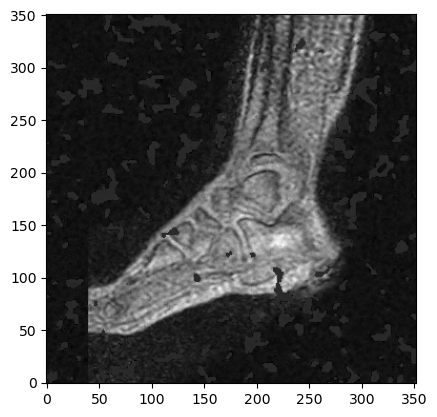

In [26]:
#Parametres pour l'entrainement et le réseau
batch_size = 5000
epochs = 50 #augmenter nombre d'epoch pour full clean et expliquer pourquoi trous
dim_hidden = 128
dim_out = 1
n_layers = 2
encoder_type = 'tcnn'
n_levels=8  #16
base_resolution= 64
per_level_scale = 1.3   #1.14
finest_resolution = None #used for non tcnn version
interpolation = 'Linear'

#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'

mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3, 7] #commencons en 2D
image_shape = data.shape
dim_in = len(data.shape)

#/!\ Normalisation -1, 1 -> 0, 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() 

axes = []
for s in image_shape:
    axes.append(torch.linspace(0, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = HashMLP(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    n_layers=n_layers,
    encoder_type=encoder_type,
    n_levels=n_levels,
    n_features_per_level=1,
    log2_hashmap_size=16,
    base_resolution=base_resolution,
    finest_resolution=finest_resolution,
    per_level_scale=per_level_scale,
    lr=1e-3,
    interpolation=interpolation
)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

plt.imshow(im.T, origin='lower', cmap='gray')

Les spots sont dus au fait que lors d'une backpropagation, seule une partie infime de l'espace de paramètres H est ajusté. Avec peu d'epochs, il est fréquent d'observer des spots sur l'image finale, mais nous gardons ce nombre pour une raison de praticité

Essayez d'ajuster les paramètres pour améliorer la qualité d'image (nombre de couches, taille de decoder) mais laissez aux valeurs par défaut pour la suite (visualisation des latents)

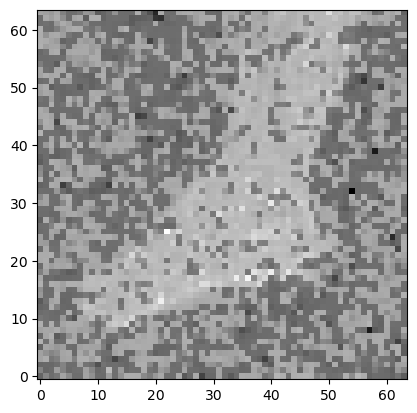

In [27]:

hash_encoding = model.encoder.params.detach() #ici, on récupère directement les paramètres H du modèle


low_freq = hash_encoding[:64 ** 2] #on récupère le premier latent de la Hash grid

len(low_freq)
low_freq = low_freq.reshape(64, 64)
low_freq = np.array(low_freq, dtype=np.float32)

plt.imshow(low_freq, origin='lower', cmap='gray')

On peut deviner la forme globale de l'image cible. Dans le cas ou la table est plus petite que la valeur max de taille de table, il n'y a pas de hashing et les données sont donc organisées

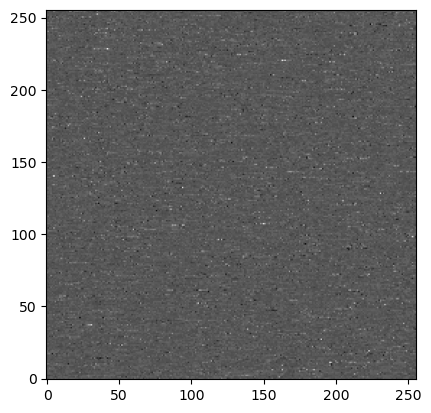

In [28]:
log2_hashmap_size=16
#high frequency
#check with hash size
high_freq = hash_encoding[-int(2 ** log2_hashmap_size):] #on récupère la dernière table H du modèle, de taille 2 ** 16

high_freq = high_freq.reshape(256, 256) #on reshape à une forme que l'on peut visualiser

    
plt.imshow(high_freq, origin='lower', cmap='gray')


L'espace de paramètres en haute résolution est désorhanisé. Comme les coordonées sont hashées avant d'être utilisés dans la table, rien n'assure la cohérence spatial des données d'une table de hash. Pour visualiser ces paramètres, nous avons besoin de passer par un loader qui va nous permettre d'extraire les visualisations intermédiaires du modèle.

In [29]:
#On passe le dataset complet en une fois, pour que les représentations intermédaires soient également complètes
test_loader = torch.utils.data.DataLoader(dataset, batch_size= 352 * 352, shuffle=False, num_workers=os.cpu_count())
model.latents = []
pred = torch.concat(trainer.predict(model, test_loader))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s] 


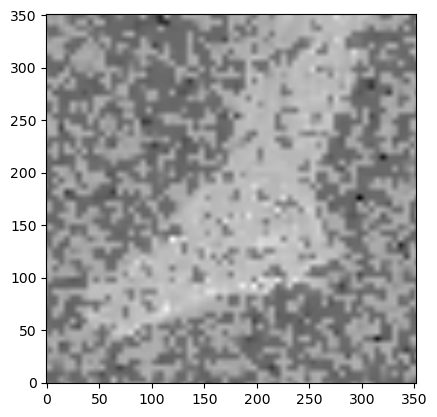

In [30]:
latents = model.latents
len(latents)
im = latents[0][:,0].reshape(352, 352)
plt.imshow(im.cpu().detach().numpy().T, origin='lower', cmap='gray')

Pour la basse résolution, on retrouve une image assez proche de l'image basse résolution obtenue.

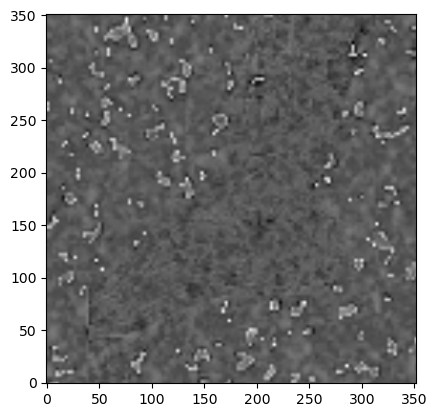

In [25]:
latents = model.latents
len(latents)
im = latents[0][:,5].reshape(352, 352)
plt.imshow(im.cpu().detach().numpy().T, origin='lower', cmap='gray')

On "devine" une forme de pied et quelques détails haute résolution. Notez également les nombreux "trous" dans la table

Trouvez la valeur minimum de log2_hashmap_size tel que le dernier latent rends une image en resolution 352 * 352

Comme la taille du decodeur n'est soumis qu'au nombre de tables hash (aisni que le nombre de paramètres par table), on peut facilement passer en dimension supérieure

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                 | Params
-------------------------------------------------
0 | encoder | ParametrizedEncoding | 72.5 M
1 | decoder | ModuleList           | 2.6 K 
-------------------------------------------------
72.5 M    Trainable params
0         Non-trainable params
72.5 M    Total params
289.990   Total estimated model params size (MB)


Epoch 49: 100%|██████████| 75/75 [00:06<00:00, 12.24it/s, loss=0.00036, v_num=118] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 75/75 [00:07<00:00,  9.52it/s, loss=0.00036, v_num=118]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 75/75 [00:01<00:00, 44.20it/s]


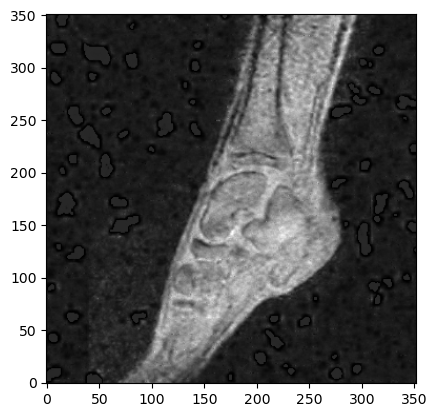

In [32]:
#Parametres pour l'entrainement et le réseau
batch_size = 25000
epochs = 50 #augmenter nombre d'epoch pour full clean et expliquer pourquoi trous
dim_hidden = 128
dim_out = 1
n_layers = 2
encoder_type = 'tcnn'
n_levels=8
base_resolution= 64
per_level_scale = 1.3
finest_resolution = None #used for non tcnn version
interpolation = 'Linear'

#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'

mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:]
image_shape = data.shape
dim_in = len(data.shape)

#/!\ Normalisation -1, 1 -> 0, 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() 

axes = []
for s in image_shape:
    axes.append(torch.linspace(0, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = HashMLP(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    n_layers=n_layers,
    encoder_type=encoder_type,
    n_levels=n_levels,
    n_features_per_level=2,
    log2_hashmap_size=23, 
    base_resolution=base_resolution,
    finest_resolution=finest_resolution,
    per_level_scale=per_level_scale,
    lr=1e-4,
    interpolation=interpolation
)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 0]

plt.imshow(im.T, origin='lower', cmap='gray')

Vous pouvez essayer de réaliser cet entrainement en précision=16 (au niveau de la déclaration du trainer) et voir l'effet sur la qualité d'image

Essayons d'interpoler quelques frames temporelles

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 149/149 [00:04<00:00, 36.29it/s]


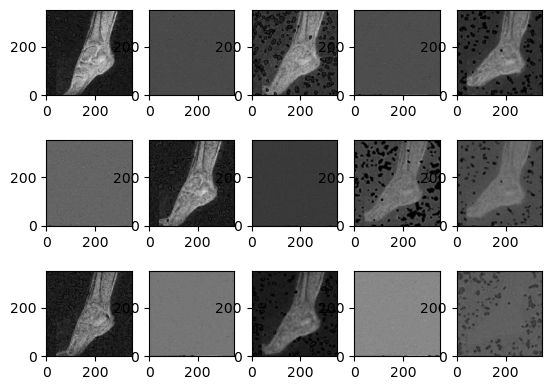

In [34]:
#dense grid
interp_shape = (352, 352, 30)
Y_interp = torch.zeros((np.prod(interp_shape), 1)) #Un mock dataset pour l'interpolation. Pas de backpropagation donc aucun effet de la valeur utilisée

axes = []
for s in interp_shape:
    axes.append(torch.linspace(0, 1, s))
        
mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)
X_interp = coords.reshape(len(Y_interp), dim_in)    

interp_dataset = torch.utils.data.TensorDataset(X_interp, Y_interp)
interp_loader = torch.utils.data.DataLoader(interp_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

#create an interpolation
interp = torch.concat(trainer.predict(model, interp_loader))

interp_im = interp.reshape(interp_shape)
    
interp_im = interp_im.detach().cpu().numpy()
interp_im = np.array(interp_im, dtype=np.float32)

if len(interp_im.shape) > 3:
    interp_im = interp_im[:,:,3,:]

fig, axes = plt.subplots(3, 5)

for j in range(5):
    for i in range(3):
        data = interp_im[..., (j * 3 + i)]
        axes[i][j].imshow(data.T, origin="lower", cmap="gray")

plt.show()

Les frames intermédiaires sont vides, voyons pourquoi

In [35]:

hash_encoding = model.encoder.params.detach()

#show basses frequences
low_freq = hash_encoding[:(128 * 128 * 128)]
# low_freq = hash_encoding[:(64 ** 3) * 2]

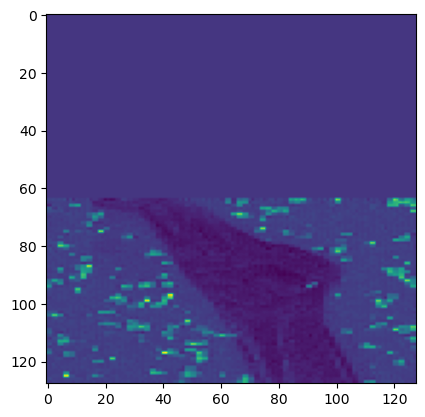

In [36]:
#Protoype, not working yet

len(low_freq)
low_freq = low_freq.reshape(128, 128, 128)
low_freq = np.array(low_freq, dtype=np.float32)

plt.imshow(low_freq[2,:,:])

# fig, axes = plt.subplots(4, 4)

# for j in range(4):
#     for i in range(4):
#         # data = low_freq[16,:,:, j * 4 + i]
#         data = low_freq[j * 4 + i,16,:, :]
#         axes[i][j].imshow(data.T, origin="lower", cmap="gray")

# plt.show()
    

Une grosses partie de l'espace des paramètres est vide !

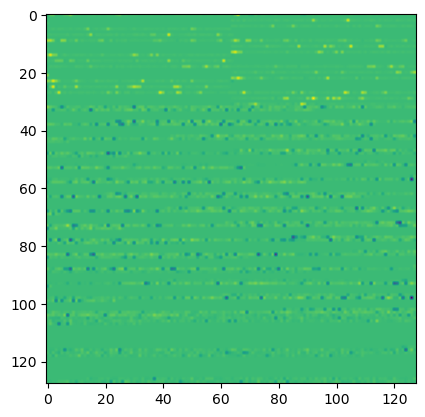

In [37]:

len(low_freq)
low_freq = low_freq.reshape(128, 128, 128)
low_freq = np.array(low_freq, dtype=np.float32)

plt.imshow(low_freq[:,:,2])  #je visualise une autre orientation

Nous voyons bien que l'espace de paramètres est organisé en "tranches" dans la dimension des frames, et que la plupart de celles-ci sont vides. Tinycuda force un espace de paramètre cubic, mais nous pouvons adapter le code pour autoriser des formes arbitraires via le code python contenu dans "encoding".

/home/aorus-users/miniconda3/envs/pytorch_ws/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | MultiResHashGridV2 | 11.4 M
1 | decoder | ModuleList         | 3.6 K 
-----------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.582    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 75/75 [00:05<00:00, 14.98it/s, loss=0.000488, v_num=119]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 75/75 [00:05<00:00, 14.15it/s, loss=0.000488, v_num=119]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 75/75 [00:01<00:00, 43.96it/s]


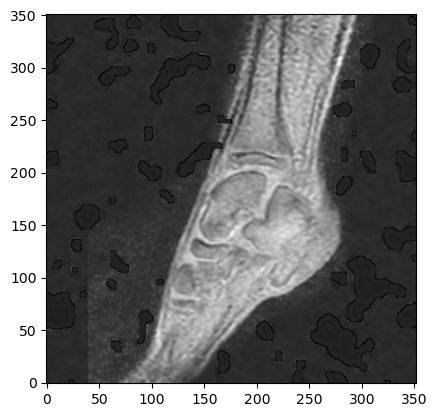

In [38]:
#Parametres pour l'entrainement et le réseau
batch_size = 25000
epochs = 50 #augmenter nombre d'epoch pour full clean et expliquer pourquoi trous
dim_hidden = 128
dim_out = 1
n_layers = 2
encoder_type = 'hash' #version pure python
n_levels=12
n_features_per_level = 1
base_resolution= (64, 64, 10) #Je déclare une résolution plus faible pour les frames, le model bascule automatiquement sur l'encoding correspondant.
per_level_scale = 2
finest_resolution = (512, 512, 20) #Paramètre utilisé pour la version non-tinycuda
interpolation = 'Linear'

#Première étape, charger une image IRM
image_path = '/mnt/Data/Equinus_BIDS_dataset/sourcedata/sub_E01/sub_E01_dynamic_MovieClear_active_run_12.nii.gz'

mri_image = nib.load(image_path)

data = mri_image.get_fdata(dtype=np.float32)
data = data[:,:,3,:] #commencons en 3D
image_shape = data.shape
dim_in = len(data.shape)

#/!\ Normalisation -1, 1 -> 0, 1
Y = torch.FloatTensor(data).reshape(-1, 1)
Y = Y / Y.max() 

axes = []
for s in image_shape:
    axes.append(torch.linspace(0, 1, s))

mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)

X = coords.reshape(len(Y), dim_in)

dataset = torch.utils.data.TensorDataset(X, Y)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = HashMLP(
    dim_in=len(data.shape),
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    n_layers=n_layers,
    encoder_type=encoder_type,
    n_levels=n_levels,
    n_features_per_level=2,
    log2_hashmap_size=23, 
    base_resolution=base_resolution,
    finest_resolution=finest_resolution,
    per_level_scale=per_level_scale,
    lr=1e-4,
    interpolation=interpolation
)

trainer = pl.Trainer(
    gpus=[0] if torch.cuda.is_available() else [],
    max_epochs=epochs,
    precision=32,
)

trainer.fit(model, train_loader)

pred = torch.concat(trainer.predict(model, test_loader))

im = pred.reshape(data.shape)
im = im.detach().cpu().numpy()
im = np.array(im, dtype=np.float32)

im = im[..., 0]

plt.imshow(im.T, origin='lower', cmap='gray')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 149/149 [00:04<00:00, 33.77it/s]


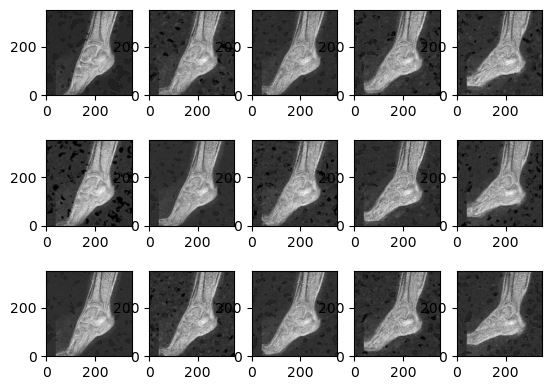

In [39]:
#dense grid
interp_shape = (352, 352, 30)
Y_interp = torch.zeros((np.prod(interp_shape), 1)) #mock dataset for interpolation loader

axes = []
for s in interp_shape:
    axes.append(torch.linspace(0, 1, s))
        
mgrid = torch.stack(torch.meshgrid(*axes, indexing='ij'), dim=-1)

coords = torch.FloatTensor(mgrid)
X_interp = coords.reshape(len(Y_interp), dim_in)    

interp_dataset = torch.utils.data.TensorDataset(X_interp, Y_interp)
interp_loader = torch.utils.data.DataLoader(interp_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

#create an interpolation
interp = torch.concat(trainer.predict(model, interp_loader))

interp_im = interp.reshape(interp_shape)
    
interp_im = interp_im.detach().cpu().numpy()
interp_im = np.array(interp_im, dtype=np.float32)

if len(interp_im.shape) > 3:
    interp_im = interp_im[:,:,3,:]

fig, axes = plt.subplots(3, 5)

for j in range(5):
    for i in range(3):
        data = interp_im[..., (j * 3 + i)]
        axes[i][j].imshow(data.T, origin="lower", cmap="gray")

plt.show()

Les frames intermédiaires sont correctement interpolées !